In [ ]:
# https://www.lottomatica.it/lotterie/lotto
# https://www.igt.it/STORICO_ESTRAZIONI_LOTTO/storico.zip
# https://living-sun.com/it/python/705402-how-can-i-extract-a-closed-zip-with-python-python-zipfile.html


In [1]:
# importazione delle librerie
import requests
import zipfile
import csv
import pandas as pd
import pandas_ta as ta
import numpy as np
import funzioni as fn
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import combinations, permutations


CLASSI

In [3]:
class Numero:

    def __init__(self, n, nome_file_ruota):

        self.precedente_ritardo = 0                     # l'ultimo ritardo conosciuto
        self.frequenze = []
        self.frequenza_attuale = 0
        self.numero = n                                 # deve essere un vettore di massimo 5 numeri
        self.dataset = fn.leggi_da_csv(nome_file_ruota) # è il dataframe di ricerca informazioni             
        self.ruota = self.dataset[1][1]
        self.ritardi = []
        self.scompensi = []
        self.scomp = 0
        self.uscite_totali = 0
        

    def info(self):
        # impostazione del vettore che memorizza il numero della estrazione in cui esce, e serve per tutti i calcoli successivi
        temp = []
        #print(self.dataset[0][2:])
        tipo = len(self.numero)
        if tipo == 1:
            for i in range(len(self.dataset)):
                #print(self.dataset[i][2:])
                if str(self.numero[0]) in self.dataset[i][2:]:
                    temp.append(i+1)
        elif tipo > 1:
            # definisce l'ambo, il terno, la quaterna o la cinquina da cercare
            temp_n = []
            for i in self.numero:
                temp_n.append(str(i))
            temp_n = tuple(temp_n)
            #print(temp_n)

            for i in range(len(self.dataset)):
                comb = list(permutations(self.dataset[i][2:], tipo))
                #print(comb)
                
                if temp_n in comb:
                    temp.append(i+1)
            #print(temp)
            
        if len(temp) == 0:
            self.precedente_ritardo = len(self.dataset) + 1
            self.ultimo_ritardo = len(self.dataset) + 1
            self.ritardo_max = len(self.dataset) + 1
            self.frequenza_attuale = 0
            self.previsione = np.NaN
            self.scomp = np.NaN
            
        elif len(temp) == 1: 
            self.precedente_ritardo = 0
            self.ultimo_ritardo = temp[0]
            self.uscite_totali = len(temp)

            # calcolo delle scompensazioni
            for i in range(1, len(temp)):
                r = temp[i] - temp[i-1]                 # Ritardo del numero nel momento in cui è uscito
                self.ritardi.append(r)                  # archivio dei ritardi
                n_estr = temp[i]                        # numero della estrazione del numero nel momento in cui è uscito
                freq = int(n_estr / len(temp[:i]))      # frequenza nel momento in cui è uscito
                self.frequenze.append(freq)
                self.scomp += (r - freq)                # scompensazione nel momento in cui è uscito
                self.scompensi.append(self.scomp)

            self.ritardo_max = temp[0]
            self.frequenza_attuale = int((len(self.dataset)+1)/(len(temp)))
            self.previsione = self.frequenza_attuale - self.ultimo_ritardo

        else:
            self.precedente_ritardo = temp[len(temp)-1] - temp[len(temp)-2] # Rutaro precedente all'ultima uscita
            self.ultimo_ritardo = len(self.dataset) - temp[len(temp)-1]     # ritardo all'ultima uscita
            self.uscite_totali = len(temp)
            
            # calcolo delle scompensazioni
            for i in range(1, len(temp)):
                r = temp[i] - temp[i-1]                 # Ritardo del numero nel momento in cui è uscito
                self.ritardi.append(r)                  # archivio dei ritardi
                n_estr = temp[i]                        # numero della estrazione del numero nel momento in cui è uscito
                freq = int(n_estr / len(temp[:i]))      # frequenza nel momento in cui è uscito
                self.frequenze.append(freq)
                self.scomp += (r - freq)                # scompensazione nel momento in cui è uscito
                self.scompensi.append(self.scomp)

            self.ritardo_max = max(self.ritardi)                        # massimo ritardo fatto dal numero
            self.frequenza_attuale = int((len(self.dataset)+1)/(len(temp)))   # frequenza attuale
            self.previsione = self.frequenza_attuale - self.ultimo_ritardo      # previsione di uscita calcolata sulla frequenza e il ritardo attiale

    def mostra_info(self):

        #valori = {
        #    "Numero" :             self.numero,
        #    "Ruota" :              self.ruota,
        #    "N. uscite" :           self.uscite_totali
        #    "Ritardo Precedente" : self.precedente_ritardo,
        #    "Ritardo Attuale" :    self.ultimo_ritardo,
        #    "Ritardo Massimo" :    self.ritardo_max,
        #    "Frequenza" :          self.frequenza_attuale,
        #    "Previsione" :         self.previsione,
        #    "Scompensazione":      self.scomp
        #}

        valori = [
            self.numero,
            self.ruota,
            self.uscite_totali,
            self.precedente_ritardo,
            self.ultimo_ritardo,
            self.ritardo_max,
            self.frequenza_attuale,
            self.previsione,
            self.scomp
            ]
    
        return valori
    
    def print_info(self):

        print(
            "\n","Numero", self.numero,
            "\n","Ruota", self.ruota,
            "\n","N. uscite", self.uscite_totali,
            "\n","Ritardo Precedente", self.precedente_ritardo,
            "\n","Ritardo Attuale", self.ultimo_ritardo,
            "\n","Ritardo Massimo", self.ritardo_max,
            "\n","Frequenza", self.frequenza_attuale,
            "\n","Previsione", self.previsione,
            "\n","Scompensazione", self.scomp
        )

    def spia(self, numero_estrezioni):
        tipo = len(self.numero)
        if tipo == 1:
            a = []
            for i in range(len(self.dataset)- numero_estrezioni):
                if str(self.numero[0]) in self.dataset[i][2:]:
                    for j in range(0, numero_estrezioni):
                        a += self.dataset[i+j][2:]
        
        risultato = trova_duplicati(a)

        return risultato





FUNZIONI

In [4]:
# Funzione per creare il dataset dei numeri in formato oggetto e richiamabili
def dataset_numeri(data):
    numeri = []
    for n in range(1, 91):
        t = Numero([n], data)
        numeri.append([n, t])
    
    return numeri

In [5]:
# Funzione per creare una tabella con tutte le statistiche di ogni numero
def print_numeri(data):
    numeri = []
    for n in range(1, 91):
        t = Numero([n], data)
        t.info()
        numeri.append(t.mostra_info())
    
    return numeri


In [6]:
# Funzione per creare una tabella con tutte le statistiche di ogni numero come un database pandas
def print_dataframe_from_numeri(data):
    numeri = print_numeri(data)
    df = pd.DataFrame(numeri, columns=[
                                        "Numero", 
                                        "Ruota", 
                                        "N. Uscite",
                                        "Ritardo Precedente",
                                        "Ritardo Attuale",
                                        "Ritardo Massimo", 
                                        "Frequenza", 
                                        "Previsione",
                                        "Scompensazione"
                                        ]
                    ).set_index(
                                [
                                    "Numero", 
                                    "Ruota"
                                ]
                            )

    return df

In [7]:
def trova_duplicati(lista):

    nya_lista = set(lista)
    counting = []
    for element in nya_lista:
        count = 0
        for i in lista:
            if element == i:
                count += 1
        counting.append([count, element])

    return counting

In [8]:
# Funzione per trovare i numeri spia in ordine 
def numeri_spia_ordinati(numero, ruota, n_est_spia, n_spie):

    temp = Numero([numero], ruota+".csv")
    temp.info()
    spie = sorted(temp.spia(n_est_spia))
    spie_ordinate = []
    for i in range(1, (n_spie+1)):
        spie_ordinate.append(int(spie[-i][1]))

    return spie_ordinate

In [9]:
# Funzione per calcolare tutti i numeri spia per ogni estrazioni
def numeri_spia_ultima_estrazione(ruota, n_est_spia, n_spie):
    ultima_riga = fn.leggi_da_csv(ruota+'.csv')[-1]
    elenco = []
    for i in ultima_riga[2:]:
        temp = numeri_spia_ordinati(int(i), ruota, n_est_spia, n_spie)
        for i in temp:
            elenco.append(i)
    #print(elenco)
    elenco_ordinato = sorted(trova_duplicati(elenco))[-n_spie:]
    spie_totali = []
    for i in elenco_ordinato:
        spie_totali.append(i[1])

    return spie_totali


In [10]:
# Funzione per trovare i 20 numeri migliori come frequenza
def migliori_numeri(ruota, n_migliori):

    lista = []
    for i in range(1, 91):
        temp = Numero([i], ruota+".csv")
        temp.info()
        lista.append([temp.uscite_totali, i])

    new_lista = sorted(lista)
    numeri = []
    for i in range(len(new_lista[-n_migliori:])):
        numeri.append(new_lista[i][1])

    return numeri

In [11]:
# Funzione per trovare i migliori 3 ambi su un tot di numeri
def migliori_ambi(numeri, ruota):

    ambi = list(combinations(numeri, 2))

    migliori = []
    for i in ambi:

        temp = Numero(i, ruota+".csv")
        temp.info()
        if temp.ultimo_ritardo < 14:
            migliori.append([temp.uscite_totali, temp.ultimo_ritardo, i])

    temp = sorted(migliori)[-3:]
    ambi_da_abbinare = []
    for i in range(len(temp)):
        ambi_da_abbinare.append(temp[i][2])

    return ambi_da_abbinare

In [12]:
def plot_graph(pf):

    pf=pf.astype(float)
    plt.rcParams["figure.figsize"] = (36, 30)
    #plt.rcParams["savefig.format"] = 'png'  

    # plotting di tutte le curve 
    plt.plot(pf['close'][:], color='blue', label='ritardo')
    plt.plot(pf["SMA_10"][:], color='red', label='SMA_10')
    plt.plot(pf["SMA_30"][:], color='green', label='SMA_30')

    # configuraione degli assi
    plt.xlabel('Numero uscita',fontsize=18)
    plt.ylabel('Riardo',fontsize=18)

    # plot signals EMA_RSI_ATR
    #plt.plot(df.index, df['BuyEMA_RSI_ATR'], '^', markersize = 15, color = 'purple', label='BuyEMA_RSI_ATR') # plot ‘Buy’ signals
    #plt.plot(df.index, df['SellEMA_RSI_ATR'], 'v', markersize = 15, color = 'black', label='SellEMA_RSI_ATR') # plot ‘Sell’ signals

    # configurazioni del titolo, leggende, griglia
    plt.title('GRAFICO', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

CODICE

In [13]:
numeri = []
for i in range(1, 91):
    numeri.append(i)

temp = Numero([23], "BA.csv")
temp.info()
#print(temp.uscite_totali)
temp.print_info()
temp.mostra_info()
spie = sorted(temp.spia(5))
#print(spie[-20:])
spie_ordinate = []
for i in range(1, 21):
    spie_ordinate.append(spie[-i][1])
print('20 Numeri spia a 5 estrazioni: \n',spie_ordinate)





 Numero [23] 
 Ruota BA 
 N. uscite 377 
 Ritardo Precedente 2 
 Ritardo Attuale 1 
 Ritardo Massimo 114 
 Frequenza 17 
 Previsione 16 
 Scompensazione -246
20 Numeri spia a 5 estrazioni: 
 ['23', '48', '89', '34', '66', '54', '90', '21', '83', '65', '30', '86', '69', '62', '71', '43', '20', '14', '81', '58']


In [ ]:
# Programma su tutte le ruote

ruote = ["BA", "FI", "MI", "NA", "PA", "RM", "TO", "VE"]
for i in ruote:

    print('Calcolo sulla ruota di', i)
    n1 = numeri_spia_ultima_estrazione(i, 5, 20)
    n2 = migliori_numeri(i, 20)
    print('Ambi da numeri spia', migliori_ambi(n1, i))
    print('Ambi da migliori numeri',migliori_ambi(n2, i))
    print('\n')

In [15]:
numero = [25,2]
dataset = fn.leggi_da_csv('BA.csv')
min = int(len(dataset)*(0.8))

tipo = len(numero)
temp_n = []
for i in numero:
    temp_n.append(str(i))
temp_n = tuple(temp_n)

temp = []
for j in range(min, len(dataset)):
    comb = list(permutations(dataset[j][2:], tipo))
    
    if temp_n in comb:
        temp.append(j+1-min)
print(temp[0])

201


In [ ]:
a = fn.leggi_da_csv('BA.csv')

for e in range(5000, len(a)+1):

    fn.scrivi_su_csv('Prova.csv', a[:e])
    fn.scrivi_su_csv('Prova2.csv', a[e+1:])

    #n1 = numeri_spia_ultima_estrazione('Prova', 5, 20)
    n1 = migliori_numeri('Prova', 20)
    print(n1)
    numero = migliori_ambi(n1, 'Prova')

    numero_str = []
    for i in numero:
        numero_str.append((str(i[0]), str(i[1])))
    print(a[e][0], numero_str)
    #numero = [('47', '73'), ('18', '44'), ('26', '72')]
    # --------------------------------------------
    # aggiungere qui la creazione delle quartine.
    # --------------------------------------------
    for i in numero_str:
        
        dataset = fn.leggi_da_csv('Prova2.csv')

        tipo = len(i)

        temp = []
        for j in range(len(dataset)):
            comb = list(permutations(dataset[j][2:], tipo))
            
            if i in comb:
                temp.append(j+1)
        print(a[e+temp[0]][0], i, temp[0])

In [80]:
df = pd.DataFrame()

temp = Numero([2], "BA.csv")
#print(temp.scompensi)
temp.info()
temp.print_info()
#print(temp.ritardi)
n = str("close")
if temp.uscite_totali > 0:
    df[n] = temp.scompensi
    sma10 = df.ta.sma(length=10)
    sma30 = df.ta.sma(length=30)
    df = pd.concat([df[n], sma10, sma30], axis=1)
    #print(list(df))
    df['temp'] = (df['SMA_10'] - df['SMA_30'])
    df['Differenza'] = df['temp'].diff()
    df['scomp_sigLine'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0 )
    df['scomp_position'] = df['scomp_sigLine'].diff()
    df["Status"] = np.where(df['scomp_sigLine'] == 0, 'Frequente', 'Ritardatario')
    df["Ritardi"] = temp.ritardi
    df["Frequenze"] = temp.frequenze
    df.to_csv("stats.csv")
else:
    print(f"{temp.numero} non è mai uscito")

#print(df[['scomp_position', 'Status']].to_string())
a = df['scomp_position'][df['scomp_position'] != 0].index[-1]
b = len(df)-1
print(
    f"Attualmente e' un numero {df['Status'][b]}, il cui ultimo cambio di stato e' avvenuto {len(df)-a} uscite fa. I suoi ultimi 3 ritardi sono {df['Ritardi'][-3:].values}"
    )

# -1 vuol dire che da scompensato cerca di tornare a compensato quindi uscirà piu frequentemente
# 1 vuol dire che da compensato cerca di tornare a scompensato quindi uscirà meno frequentemente


 Numero [2] 
 Ruota BA 
 N. uscite 361 
 Ritardo Precedente 9 
 Ritardo Attuale 31 
 Ritardo Massimo 105 
 Frequenza 18 
 Previsione -13 
 Scompensazione 145
Attualmente e' un numero Ritardatario, il cui ultimo cambio di stato e' avvenuto 1 uscite fa. I suoi ultimi 3 ritardi sono [9 5 9]


Attualmente e' un numero Frequente, il cui ultimo cambio di stato e' avvenuto 9 uscite fa. I suoi ultimi 3 ritardi sono [ 9 21  2]


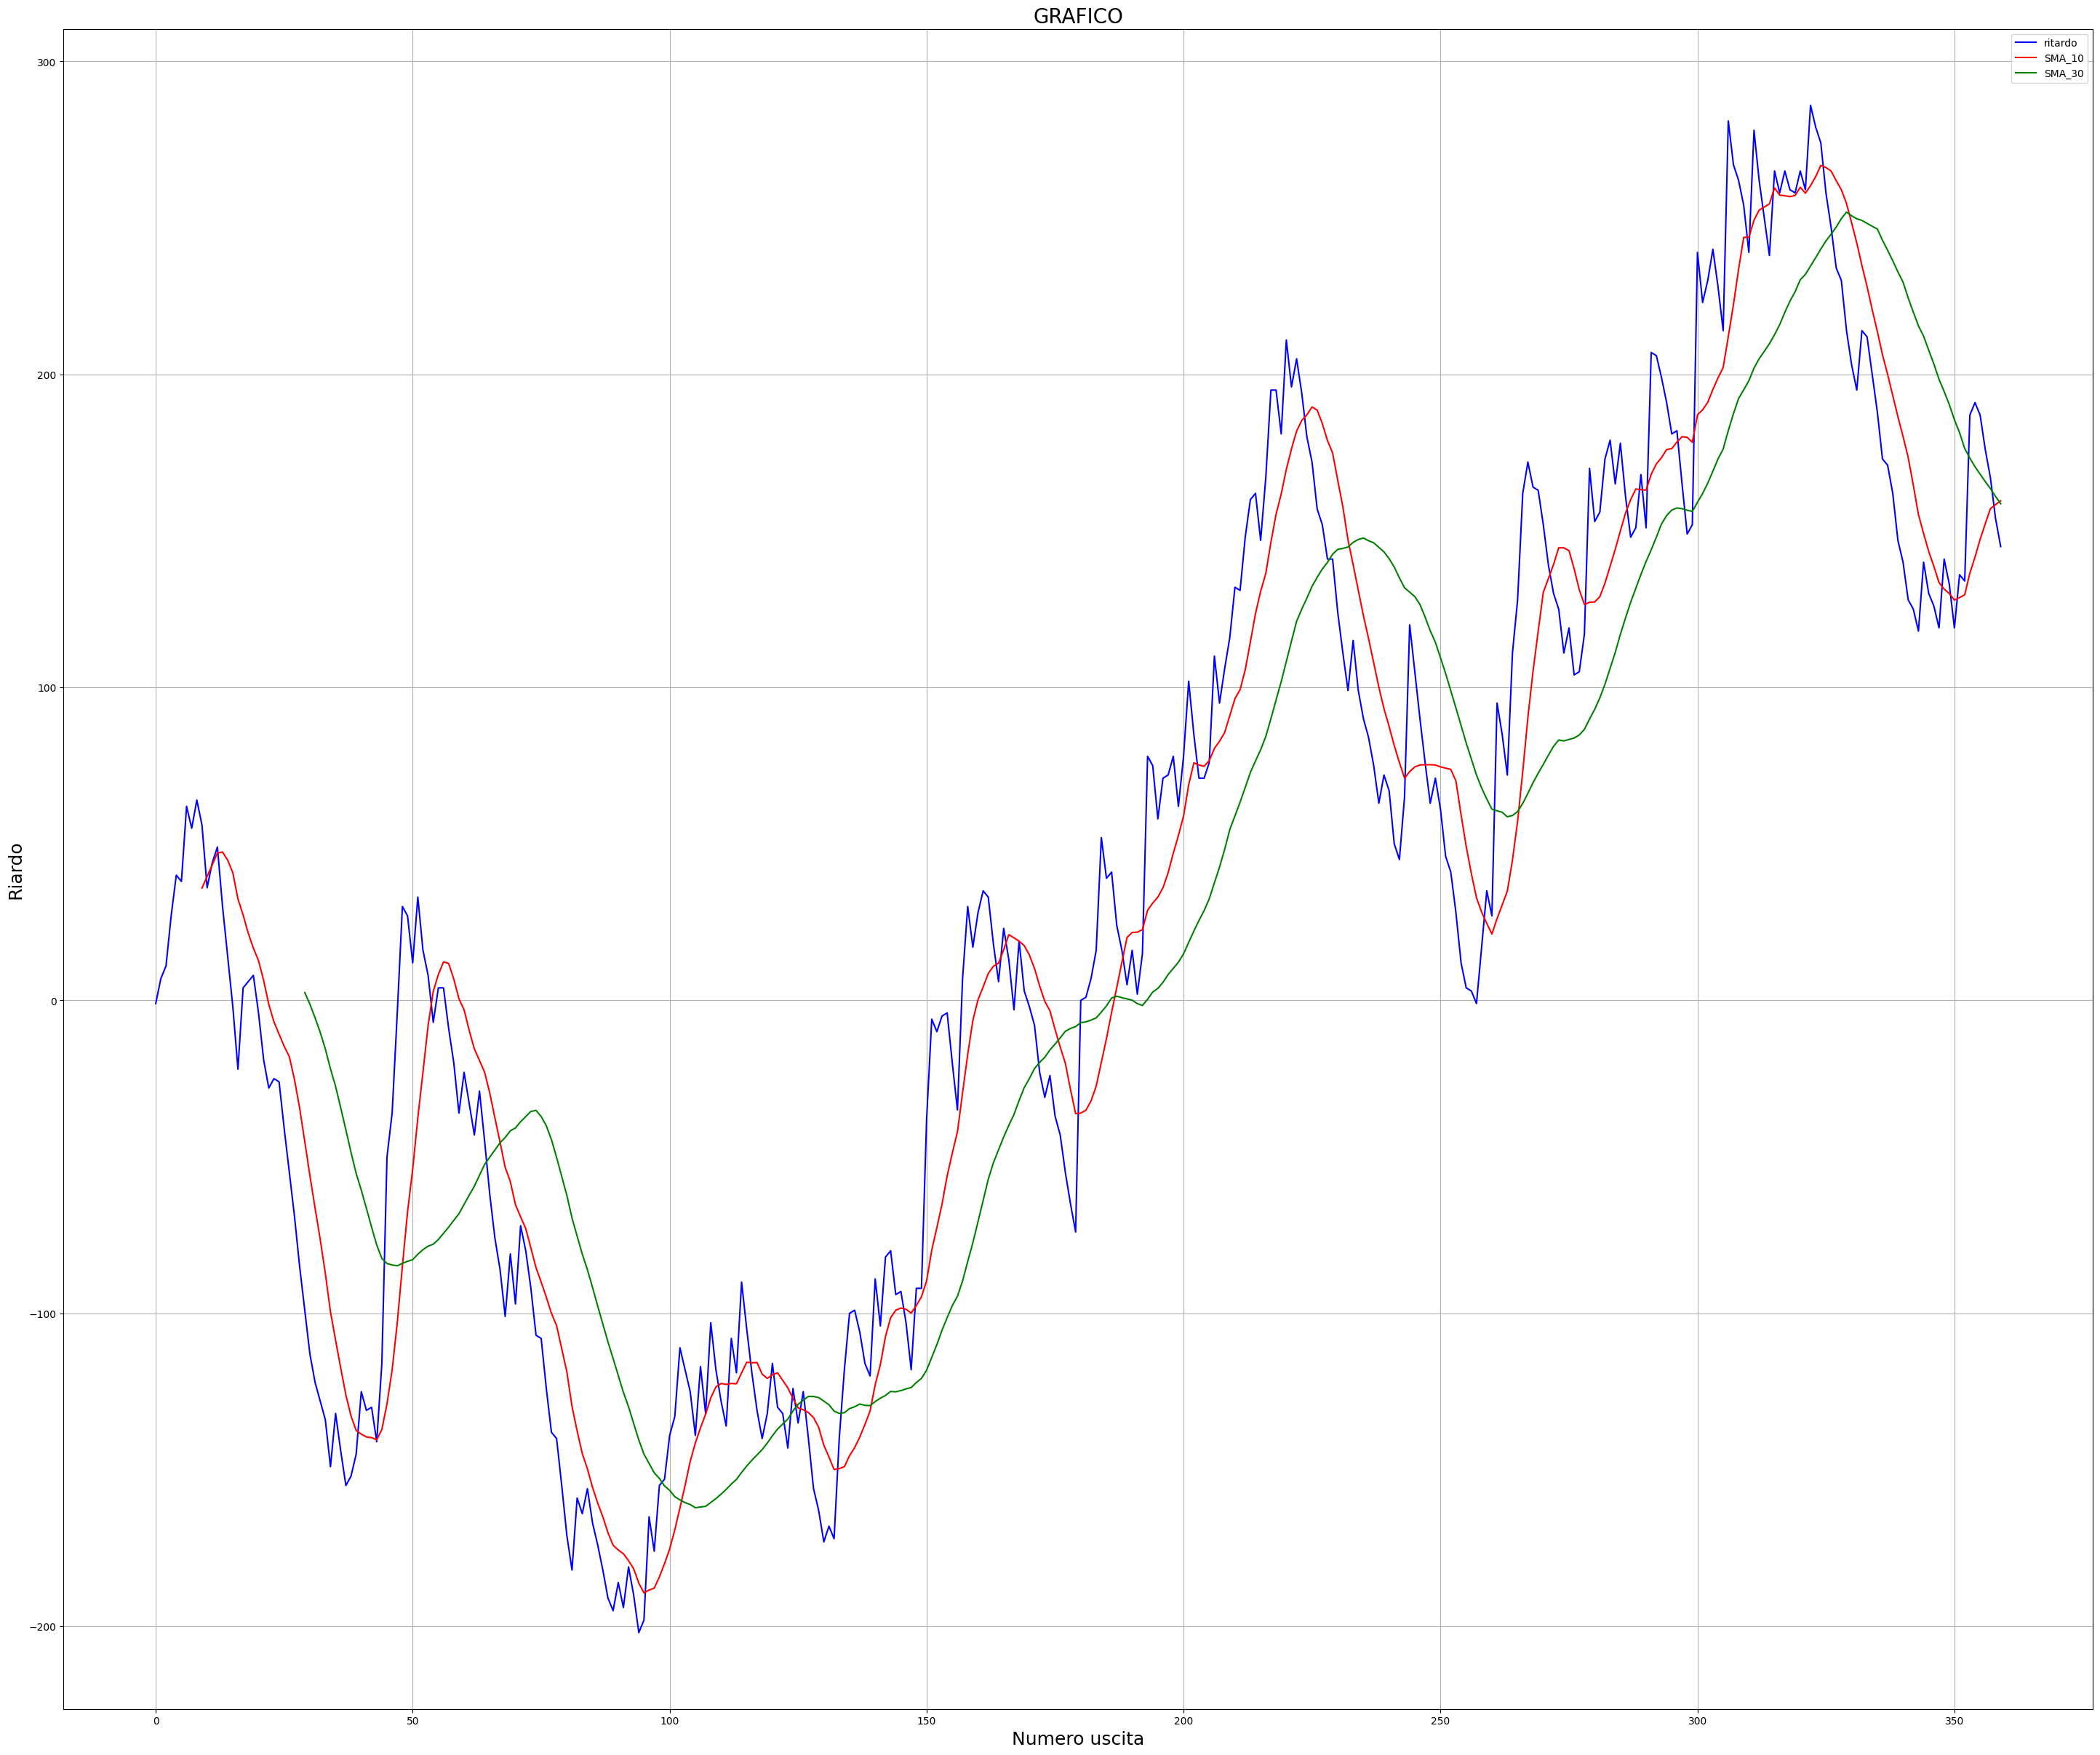

In [81]:
plot_graph(df[['close', 'SMA_10', 'SMA_30']])

In [ ]:
# prendere i migliori 20 estratti per ruota in base al numero di volte che sono usciti (i piu' prequenti)
# nelle ultime estrazioni del mese precedente l'estrazione verifico che ambi sono usciti nei 20 numeri
# i migliori 3 ambi le rigioco in quartine per altre 13 estrazioni successive

In [74]:
lista = []
for i in range(1, 91):
    temp = Numero([i], "BA.csv")
    temp.info()
    lista.append([temp.uscite_totali, i])
    #print(temp.uscite_totali)
    #temp.print_info()
    #temp.mostra_info()

new_lista = sorted(lista)
numeri = []
for i in range(len(new_lista[-20:])):
    #print(new_lista[i][1])
    numeri.append(new_lista[i][1])

print(numeri)

ambi = list(combinations(numeri, 2))

#print(ambi)
migliori = []
for i in ambi:

    temp = Numero(i, "BA.csv")
    #print(temp.scompensi)
    temp.info()
    #temp.print_info()
    if temp.ultimo_ritardo < 14:
        print(i, temp.ultimo_ritardo, temp.uscite_totali)
        migliori.append([temp.uscite_totali, temp.ultimo_ritardo, i])

temp = sorted(migliori)[-3:]
ambi_da_abbinare = []
for i in range(len(temp)):
    ambi_da_abbinare.append(temp[i][2])

quartine = list(combinations(ambi_da_abbinare, 2))
print(quartine)


[24, 45, 25, 7, 21, 6, 41, 38, 57, 64, 43, 72, 39, 28, 32, 42, 52, 67, 63, 80]
(24, 42) 5 8
(25, 6) 13 17
(25, 64) 13 14
(21, 41) 10 18
(21, 38) 0 16
(21, 72) 4 16
(6, 64) 13 14
(43, 39) 9 18
(39, 42) 11 15
[((25, 6), (43, 39)), ((25, 6), (21, 41)), ((43, 39), (21, 41))]
